# Hourly Forecasting Carbon Intensity using SARIMA #

## Importing modules ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import time
import sys, os

# Add path to power_monitor
sys.path.append(os.path.abspath('../LibreHardwareMonitor-net472'))
from power_monitor import PowerMonitor

# Dictionary to store execution times and power stats
execution_times = {}
power_stats = {}

In [2]:
with PowerMonitor("Hourly_SARIMA_Forecasting.csv") as pmon:
    start_time = time.time()
    df = pd.read_csv('../data/df_fuel_ckan.csv')
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])

    # Filter for history and the test year (2025)
    df_filtered = df[df['DATETIME'].dt.year < 2025].copy().set_index('DATETIME')
    df_2025 = df[df['DATETIME'].dt.year == 2025].copy().set_index('DATETIME')

    # Use 30 days for balance between speed and accuracy
    data_train = df_filtered['CARBON_INTENSITY'].resample('h').mean().interpolate().tail(24 * 30)
    actual_2025 = df_2025['CARBON_INTENSITY'].resample('h').mean().interpolate()

    def create_time_features(index):
        """Create enhanced time-based features for better pattern capture"""
        df_feat = pd.DataFrame(index=index)
        df_feat['hour'] = index.hour / 23.0  # Normalize to [0,1]
        df_feat['day_of_week'] = index.dayofweek / 6.0
        # IMPROVED: Added more features for better pattern recognition
        df_feat['day_of_month'] = index.day / 31.0
        df_feat['week_of_year'] = index.isocalendar().week / 52.0
        return df_feat.values

    X_train = create_time_features(data_train.index)
    X_future = create_time_features(actual_2025.index)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(data_train.values.reshape(-1, 1)).flatten()
    
    execution_times['Data Processing'] = time.time() - start_time
power_stats['Data Processing'] = pmon.stats()


In [3]:
with PowerMonitor("Hourly_SARIMA_Forecasting.csv") as pmon:
    start_time = time.time()
    stepwise_model = pm.auto_arima(
        y=y_train_scaled,
        X=X_train,
        seasonal=True,
        m=24,
        start_p=1, start_q=1, 
        start_P=0, start_Q=0,
        max_p=3, max_q=2,
        max_P=1, max_Q=1,
        d=None, D=None,
        max_d=2, max_D=1,
        test='adf',
        seasonal_test='ocsb',
        stepwise=False,
        n_jobs=1,
        suppress_warnings=True,
        error_action='ignore',
        information_criterion='aic',
        trace=True,
        with_intercept=False,
        maxiter=50,
        method='lbfgs'
    )
    execution_times['Model Training'] = time.time() - start_time
power_stats['Model Training'] = pmon.stats()


 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-795.961, Time=0.37 sec
 ARIMA(0,1,0)(0,0,1)[24]             : AIC=-889.473, Time=1.18 sec
 ARIMA(0,1,0)(1,0,0)[24]             : AIC=-918.315, Time=2.04 sec
 ARIMA(0,1,0)(1,0,1)[24]             : AIC=inf, Time=5.41 sec
 ARIMA(0,1,1)(0,0,0)[24]             : AIC=-1129.187, Time=0.72 sec
 ARIMA(0,1,1)(0,0,1)[24]             : AIC=-1176.703, Time=3.13 sec
 ARIMA(0,1,1)(1,0,0)[24]             : AIC=-1191.306, Time=1.87 sec
 ARIMA(0,1,1)(1,0,1)[24]             : AIC=inf, Time=4.29 sec
 ARIMA(0,1,2)(0,0,0)[24]             : AIC=-1178.011, Time=0.57 sec
 ARIMA(0,1,2)(0,0,1)[24]             : AIC=-1215.385, Time=1.69 sec
 ARIMA(0,1,2)(1,0,0)[24]             : AIC=-1225.187, Time=2.40 sec
 ARIMA(0,1,2)(1,0,1)[24]             : AIC=inf, Time=3.78 sec
 ARIMA(1,1,0)(0,0,0)[24]             : AIC=-1152.154, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[24]             : AIC=-1193.894, Time=2.15 sec
 ARIMA(1,1,0)(1,0,0)[24]             : AIC=-1203.774, Time=2.18 sec
 

In [4]:
with PowerMonitor("Hourly_SARIMA_Forecasting.csv") as pmon:
    start_time = time.time()
    forecast_scaled = stepwise_model.predict(
        n_periods=len(actual_2025),
        X=X_future
    )

    # Inverse transform to original scale
    forecast_values = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
    forecast_series = pd.Series(forecast_values, index=actual_2025.index)
    execution_times['Forecasting'] = time.time() - start_time
power_stats['Forecasting'] = pmon.stats()



Performance Metrics:
MAE: 57.46 gCO2/kWh
RMSE: 73.49 gCO2/kWh


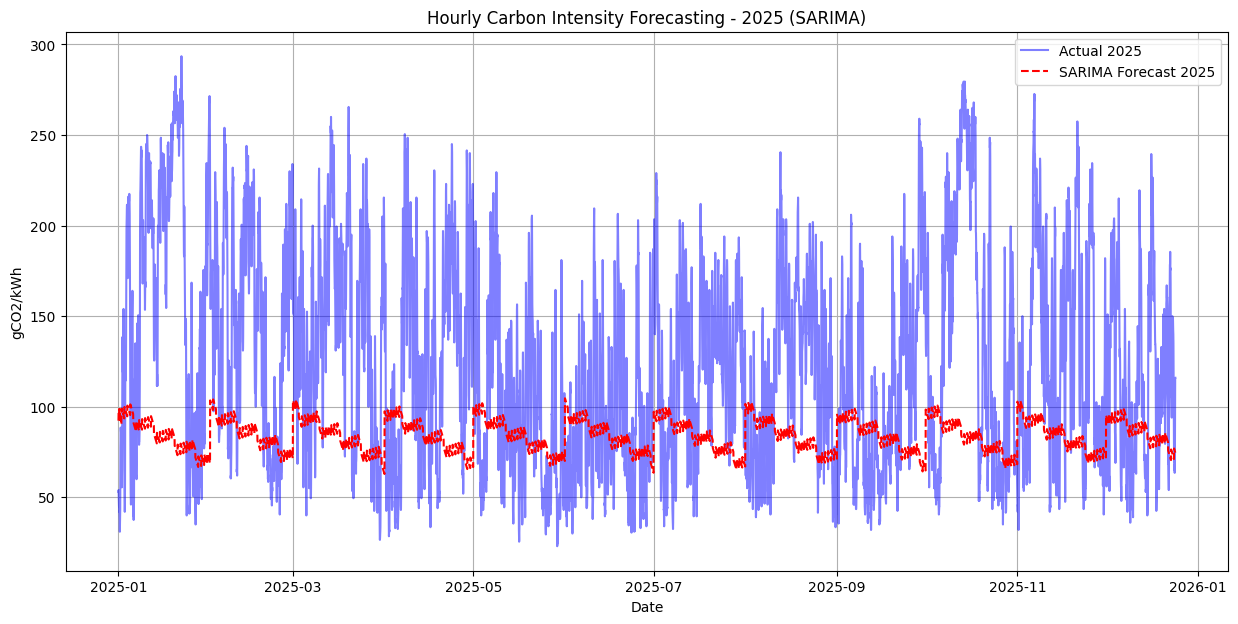

In [5]:
val_mae = mean_absolute_error(actual_2025, forecast_values)
val_rmse = np.sqrt(mean_squared_error(actual_2025, forecast_values))

print(f"\nPerformance Metrics:")
print(f"MAE: {val_mae:.2f} gCO2/kWh")
print(f"RMSE: {val_rmse:.2f} gCO2/kWh")

plt.figure(figsize=(15, 7))
plt.plot(actual_2025.index, actual_2025, label='Actual 2025', color='blue', alpha=0.5)
plt.plot(forecast_series.index, forecast_series, label='SARIMA Forecast 2025', color='red', linestyle='--')
plt.title('Hourly Carbon Intensity Forecasting - 2025 (SARIMA)')
plt.xlabel('Date')
plt.ylabel('gCO2/kWh')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
print("EXECUTION TIME AND ENERGY SUMMARY")
total_time = 0
for task, duration in execution_times.items():
    print(f"{task}: {duration:.4f} seconds")
    if task in power_stats:
        print(f"  Power: {power_stats[task]}")
    total_time += duration
print(f"Total Execution Time: {total_time:.4f} seconds")

print("\nPOWER MONITOR FINAL STATS")
print(pmon.stats())
print("Energy stats saved to: Hourly_SARIMA_Forecasting.csv")
# Print power usage summary
print("\nPOWER USAGE SUMMARY")
for task, stats in power_stats.items():
    print(f"{task}: {stats}")

# Calculate and print total energy used by the program
print("\n" + "="*50)
print("TOTAL ENERGY USED (Average Power × Runtime)")
print("="*50)

total_energy_joules = 0
for task, stats in power_stats.items():
    if stats and task in execution_times:
        # Sum up average power from all components (CPU Package, CPU Cores, CPU Memory, CPU Platform, GPU Power)
        total_avg_power = 0
        for component, data in stats.items():
            if isinstance(data, dict) and 'avg' in data:
                total_avg_power += data['avg']
        
        runtime = execution_times[task]
        energy = total_avg_power * runtime  # Energy in Joules = Power (Watts) × Time (seconds)
        total_energy_joules += energy
        print(f"{task}: {total_avg_power:.2f}W × {runtime:.4f}s = {energy:.2f}J")

print(f"\nTotal Energy Used: {total_energy_joules:.2f} Joules")
print(f"Total Energy Used: {total_energy_joules/1000:.4f} kJ (kilojoules)")
print("="*50)

EXECUTION TIME AND ENERGY SUMMARY
Data Processing: 1.3132 seconds
  Power: {'CPU Package': {'min': 11.524511337280273, 'max': 15.598424911499023, 'avg': 13.843761126200357, 'samples': 3}, 'CPU Cores': {'min': 7.478979587554932, 'max': 11.788484573364258, 'avg': 9.870088736216227, 'samples': 3}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 3}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 3}, 'GPU Power': {'min': 0.014350567944347858, 'max': 0.031357649713754654, 'avg': 0.02001959520081679, 'samples': 3}}
Model Training: 104.3007 seconds
  Power: {'CPU Package': {'min': 9.114835739135742, 'max': 22.381999969482422, 'avg': 16.67994929101183, 'samples': 193}, 'CPU Cores': {'min': 5.922825813293457, 'max': 20.522348403930664, 'avg': 13.397518923863228, 'samples': 193}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 193}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 193}, 'GPU Power': {'min': 0.0068720425479114056, 'max': 